Image Preprocessing for Deep Learning (PyTorch & TensorFlow)
Introduction: Why Preprocessing is Essential
In the realm of deep learning, especially with Convolutional Neural Networks (CNNs) for computer vision tasks, images serve as the primary input. However, raw image data is often inconsistent, noisy, or not in an optimal format for direct consumption by neural networks. This is where image preprocessing comes into play.

Technological Background:
Deep learning models, particularly CNNs, are highly sensitive to the input data's scale, distribution, and consistency. They learn to extract hierarchical features from images by identifying patterns. If the input images vary greatly in size, brightness, contrast, or orientation, the model might struggle to converge effectively, learn robust features, or generalize well to unseen data.

Why Preprocessing is Needed:

Standardization of Input: Neural networks, especially fixed-architecture CNNs, require inputs of a consistent size and format. Preprocessing ensures all images conform to these requirements.

Normalization of Pixel Values: Raw pixel values (typically 0-255 for 8-bit images) can lead to large gradients during training, slowing down convergence or causing instability. Normalizing them to a smaller, consistent range (e.g., 0-1 or -1 to 1) helps the optimization process.

Noise Reduction: Real-world images often contain noise (e.g., sensor noise, compression artifacts). Preprocessing techniques can help mitigate this noise, allowing the model to focus on meaningful features.

Feature Enhancement: Some preprocessing steps can enhance specific features, like edges or textures, which can be beneficial for certain tasks.

Data Augmentation: This is a crucial preprocessing technique that artificially expands the training dataset by applying various transformations (e.g., rotations, flips, zooms). This helps prevent overfitting and improves the model's generalization capability by exposing it to a wider variety of plausible inputs.

Computational Efficiency: Reducing image dimensions or converting to grayscale can reduce the computational burden and memory footprint, making training more efficient.

Without proper preprocessing, deep learning models might:

Exhibit slower convergence during training.

Achieve lower accuracy and generalization performance.

Be more prone to overfitting.

Require more computational resources.

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2 # Import v2 for modern transforms
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
import skimage
from skimage import data
from skimage import transform
import matplotlib.image as mpimg

print(f"PyTorch Version: {torch.__version__}")
print(f"TensorFlow Version: {tf.__version__}")

PyTorch Version: 2.6.0+cu124
TensorFlow Version: 2.18.0


Data Acquisition (Example Image)
For demonstration purposes, we'll download a sample image. In a real scenario, you'd typically load a dataset of images.

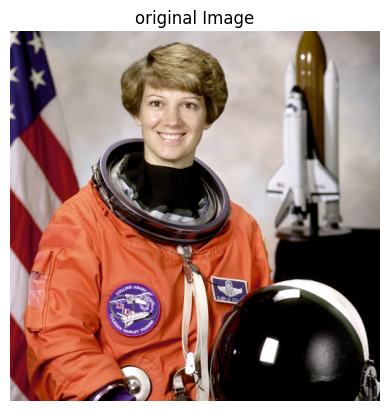

In [11]:
#Reading an image
original_image = data.astronaut()  # Sample RGB image from skimage
plt.title("original Image")
plt.imshow(original_image)
plt.axis('off')
plt.show()

In [61]:
#checking shape
image = original_image
image.shape

(512, 512, 3)

(512, 1536)


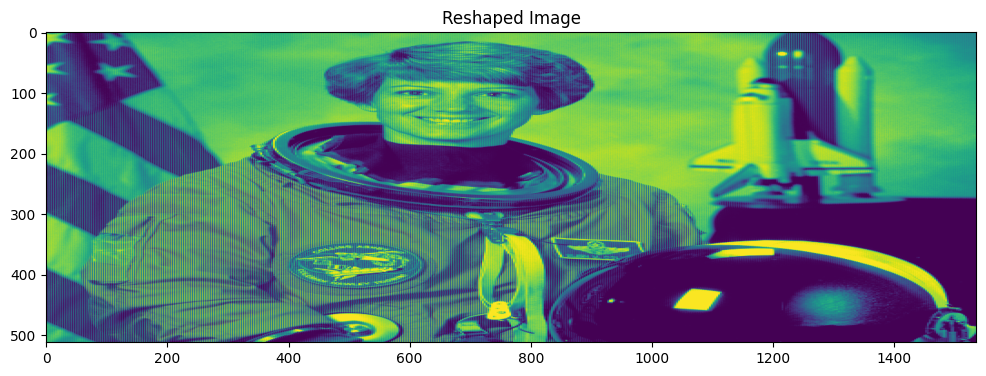

In [62]:
# preserving the height of the image and reshaping the width  and channel values
reshaped_image = image.reshape(image.shape[0],-1)
print(reshaped_image.shape)

plt.figure(figsize = (12,12))
plt.title("Reshaped Image")
plt.imshow(reshaped_image)

(100, 300, 3)


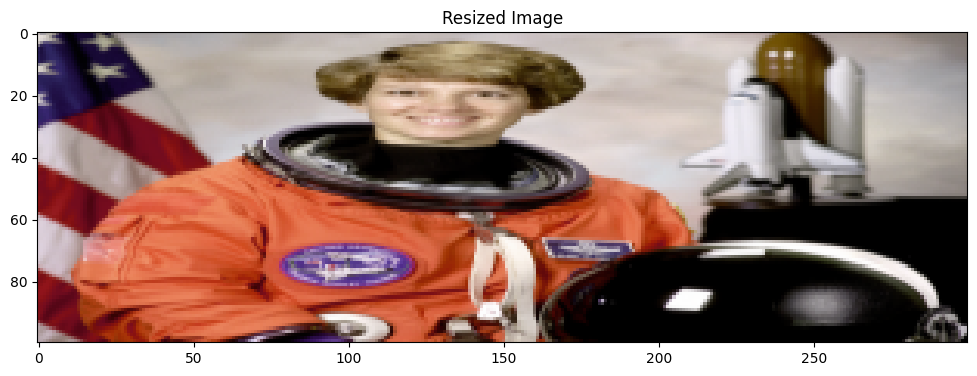

In [63]:
# resize the original image to 100 by 300
image_resized = skimage.transform.resize(image,(100,300))
print(image_resized.shape)

plt.figure(figsize = (12,12))
plt.title("Resized Image")
plt.imshow(image_resized)

(512, 512, 3)


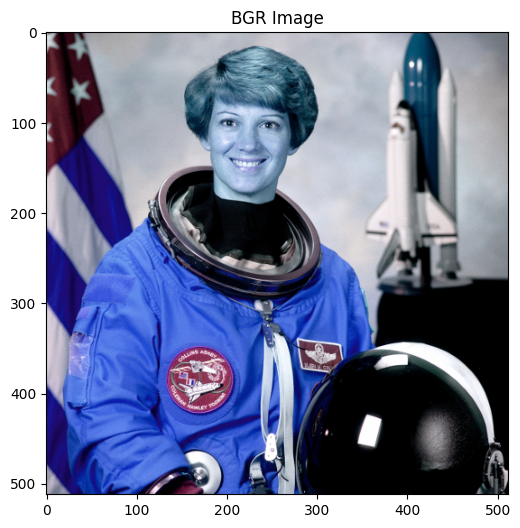

In [64]:
### Reversing color order from RGB to BGR
# Used in certain frameworks such as OpenCV

image_BGR = image[:,:,(2,1,0)]
print(image_BGR.shape)

plt.figure(figsize=(6,6))
plt.title("BGR Image")
plt.imshow(image_BGR)

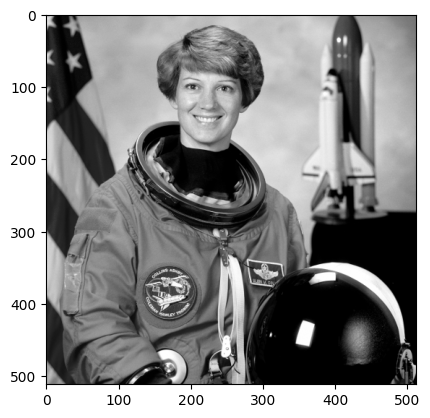

In [65]:
### Gray scale
## transfroming a color image to a gray image
image_gray = skimage.color.rgb2gray(image)
plt.imshow(image_gray, cmap = 'gray')

Image Preprocessing with PyTorch
PyTorch's torchvision.transforms module provides a rich set of common image transformations. These transformations can be chained together using transforms.Compose.

Let's assume our model expects input images of size 224x224, normalized to a specific mean and standard deviation.

PyTorch preprocessed image shape: torch.Size([3, 224, 224])
PyTorch preprocessed image min value: -2.1179039478302
PyTorch preprocessed image max value: 2.6225709915161133


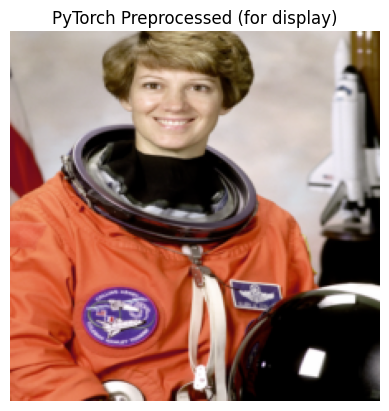

In [15]:
# Convert PIL Image to PyTorch Tensor (CHW format)
    # Why v2.ToImage() is needed: It's the recommended way in v2 to convert various input types
    # (like PIL Images, NumPy arrays) into a torch.Tensor. This also handles the dimension
    # rearrangement to Channel-Height-Width (CHW) format, which is standard for PyTorch.
img_tensor = v2.ToImage()(original_image)

    # Define a sequence of transformations for preprocessing and augmentation
    # Why v2.Compose is needed: It allows you to chain multiple transformations together
    # in a sequential manner, applying them one after another to the image tensor.
pytorch_v2_transforms = v2.Compose([
        # 1. Convert to uint8 (optional, but good practice for raw image data)
        # Why it's needed: Many raw image formats are 8-bit, and working with uint8 initially
        # can ensure data integrity before floating-point conversions. `scale=True` means
        # it will handle scaling if the input is not already in the 0-255 range.
    v2.ToDtype(torch.uint8, scale=True),

        # 2. RandomResizedCrop
        # Why it's needed: This is a powerful data augmentation technique. Instead of just resizing,
        # it first takes a random crop of the image (with a random size and aspect ratio) and then
        # resizes it to the specified `size` (224, 224). This helps the model become robust to
        # objects appearing at different scales and positions within the image.
        # `antialias=True` ensures smoother downsampling by applying an anti-aliasing filter,
        # which can improve image quality and model performance, especially when resizing significantly.
    v2.RandomResizedCrop(size=(224, 224), antialias=True),

        # 3. RandomHorizontalFlip
        # Why it's needed: A common data augmentation technique that randomly flips the image
        # horizontally with a given probability (here, 0.5 or 50%). This helps the model
        # learn to recognize objects regardless of their left-right orientation, increasing
        # the diversity of the training data and reducing overfitting.
        v2.RandomHorizontalFlip(p=0.5),

        # 4. Convert to float32
        # Why it's needed: Deep learning models typically perform computations with floating-point
        # numbers (e.g., float32). This step converts the pixel values from integer (uint8)
        # to float, and `scale=True` automatically normalizes them from the [0, 255] range to [0.0, 1.0].
    v2.ToDtype(torch.float32, scale=True),

        # 5. Normalize
        # Why it's needed: Normalization scales the pixel values of the image to a standard range
        # using the dataset's mean and standard deviation. This is crucial for:
        #   - Faster convergence: Input features with similar scales prevent some features
        #     from dominating others, leading to more stable and faster training.
        #   - Improved performance: Many pre-trained models (e.g., from ImageNet) are trained
        #     with specific normalization parameters. Applying the same normalization ensures
        #     the new input data aligns with what the pre-trained model expects.
        # The values (0.485, 0.456, 0.406) and (0.229, 0.224, 0.225) are common
        # mean and standard deviation for images trained on ImageNet.
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Apply the transformations
preprocessed_pytorch_image = pytorch_v2_transforms(img_tensor)

print(f"PyTorch preprocessed image shape: {preprocessed_pytorch_image.shape}")
print(f"PyTorch preprocessed image min value: {preprocessed_pytorch_image.min()}")
print(f"PyTorch preprocessed image max value: {preprocessed_pytorch_image.max()}")

    # Display the preprocessed image (denormalize for visualization)
    # Why denormalize for visualization: The `Normalize` transform shifts the pixel values
    # away from the standard [0,1] or [0,255] range, making direct visualization difficult
    # and potentially showing a black image. Denormalizing brings it back to a viewable range.
    # The normalization formula is: normalized = (pixel - mean) / std
    # So, to denormalize: pixel = normalized * std + mean
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) # Reshape for broadcasting (C, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) # Reshape for broadcasting (C, 1, 1)

display_image_pytorch = preprocessed_pytorch_image * std + mean

    # Clamp values to [0, 1] as some denormalized values might fall outside this range
    # Why clamping: Pixel values typically range from 0 to 1 (or 0 to 255). Due to floating-point
    # arithmetic and the normalization/denormalization process, some pixel values might slightly
    # exceed 1 or go below 0. Clamping ensures they stay within a valid displayable range.
display_image_pytorch = display_image_pytorch.clamp(0, 1)

plt.figure()
plt.imshow(display_image_pytorch.permute(1, 2, 0).numpy()) # PyTorch is C,H,W; Matplotlib expects H,W,C
plt.title("PyTorch Preprocessed (for display)")
plt.axis('off')
plt.show()




Image Preprocessing with TensorFlow
TensorFlow's tf.image module provides a comprehensive set of functions for image manipulation. TensorFlow's approach often involves applying these operations as part of the tf.data.Dataset pipeline for efficient data loading and preprocessing.

TensorFlow preprocessed image shape: (224, 224, 3)
TensorFlow preprocessed image min value: 0.0
TensorFlow preprocessed image max value: 1.0


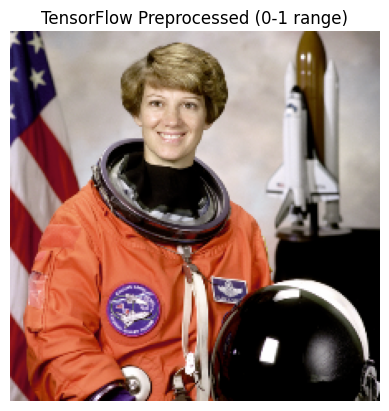

In [23]:
# Convert PIL image to TensorFlow tensor
    # Why it's needed: TensorFlow operations work on tf.Tensor objects. This converts the image.
    # We also cast to float32 as neural networks typically operate on floating-point numbers.
raw_tf_image = tf.convert_to_tensor(np.array(original_image), dtype=tf.float32)

    # Add a batch dimension (TensorFlow often expects BATCH, HEIGHT, WIDTH, CHANNELS)
    # Why it's needed: Many TensorFlow image operations and model inputs expect a batch dimension,
    # even if you are processing a single image. This transforms (H, W, C) to (1, H, W, C).
raw_tf_image1 = tf.expand_dims(raw_tf_image, 0)

    # 1. Resize
    # Why it's needed: Similar to PyTorch, models require consistent input dimensions.
    # tf.image.resize handles interpolation methods (e.g., bilinear, nearest_neighbor).
resized_tf_image = tf.image.resize(raw_tf_image1, [224, 224])

    # 2. Normalize Pixel Values (to 0-1 range)
    # Why it's needed: Rescaling pixels from [0, 255] to [0, 1] is a common normalization step.
    # This helps stabilize training and is often a prerequisite for further normalization
    # (e.g., mean and std normalization).
normalized_tf_image_01 = resized_tf_image / 255.0

    # 3. Normalize Pixel Values (to -1 to 1 range, often used by certain models)
    # Why it's needed: Some neural network architectures (e.g., GANs or specific pre-trained models)
    # prefer input values in the range of [-1, 1]. This normalization centers the data around zero.
normalized_tf_image_neg1_1 = (normalized_tf_image_01 * 2.0) - 1.0

    # For display, we'll use the 0-1 normalized image
preprocessed_tf_image = normalized_tf_image_01[0] # Remove batch dimension for display

print(f"TensorFlow preprocessed image shape: {preprocessed_tf_image.shape}")
print(f"TensorFlow preprocessed image min value: {preprocessed_tf_image.numpy().min()}")
print(f"TensorFlow preprocessed image max value: {preprocessed_tf_image.numpy().max()}")

plt.figure()
plt.imshow(preprocessed_tf_image.numpy()) # TensorFlow is H,W,C
plt.title("TensorFlow Preprocessed (0-1 range)")
plt.axis('off')
plt.show()

# --- Data Augmentation Examples (PyTorch v2) ---
    

    # Why data augmentation is needed: It's a crucial technique to prevent overfitting in deep learning models.
    # By creating slightly modified copies of existing training data, it artificially increases the size
    # and diversity of the training set. This helps the model generalize better to unseen data and
    # become more robust to variations in input (e.g., slight rotations, shifts, changes in brightness).

    # For demonstration, we'll apply the same transforms defined above as they include augmentation
    # If you wanted more specific augmentations, you'd add more v2 transforms here.


--- PyTorch Data Augmentation Examples (using v2) ---


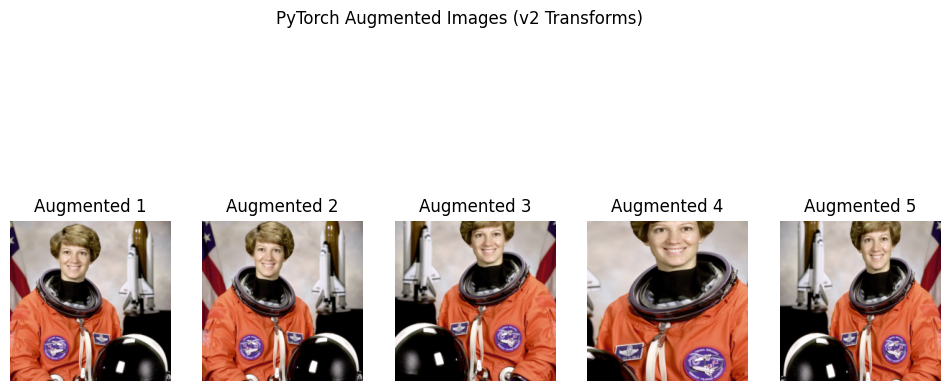

In [18]:
print("\n--- PyTorch Data Augmentation Examples (using v2) ---")

plt.figure(figsize=(12, 6))
for i in range(5):
    augmented_image_v2 = pytorch_v2_transforms(img_tensor) # Apply the combined transforms
    # Denormalize for display
    display_augmented_image_v2 = augmented_image_v2 * std + mean
    display_augmented_image_v2 = display_augmented_image_v2.clamp(0, 1)

    plt.subplot(1, 5, i + 1)
    plt.imshow(display_augmented_image_v2.permute(1, 2, 0).numpy())
    plt.title(f"Augmented {i+1}")
    plt.axis('off')
plt.suptitle("PyTorch Augmented Images (v2 Transforms)")
plt.show()

# --- Data Augmentation Examples (TensorFlow) ---
    print("\n--- TensorFlow Data Augmentation Examples ---")

    # Data augmentation in TensorFlow is often done using `tf.keras.layers.experimental.preprocessing`
    # or directly with `tf.image` functions within a `tf.data` pipeline.

    # Convert original image to tensor (without adding batch dim here, will add inside the function)
    raw_tf_image = tf.convert_to_tensor(np.array(original_image), dtype=tf.float32)

    

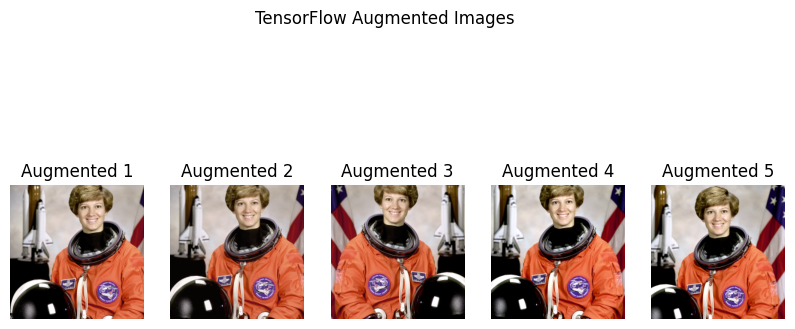

In [24]:
def tensorflow_augment(image_tensor):
    # Why it's needed: Similar to PyTorch, to prevent overfitting and improve generalization.
      # These operations are applied randomly during training.

      # Resize (first step for consistent input size)
    image_tensor = tf.image.resize(image_tensor, [256, 256])

        # Random Crop
        # Why it's needed: Helps the model learn to recognize objects even when partially obscured
        # or in different positions within the image. `random_crop` takes a single image (H, W, C).
    image_tensor = tf.image.random_crop(image_tensor, size=[224, 224, 3])

        # Random Horizontal Flip
        # Why it's needed: Creates new training samples by mirroring the image, useful for objects
        # that are symmetric or can appear in any orientation.
    image_tensor = tf.image.random_flip_left_right(image_tensor)

        # Random Brightness
        # Why it's needed: Makes the model robust to varying lighting conditions.
    image_tensor = tf.image.random_brightness(image_tensor, max_delta=0.2) # Max delta for brightness change

        # Random Contrast
        # Why it's needed: Makes the model robust to varying contrast levels.
    image_tensor = tf.image.random_contrast(image_tensor, lower=0.8, upper=1.2) # Factor range for contrast

        # Normalize to 0-1
    image_tensor = image_tensor / 255.0

    return image_tensor

plt.figure(figsize=(10, 5))
for i in range(5):
      augmented_tf_image = tensorflow_augment(raw_tf_image)
      plt.subplot(1, 5, i + 1)
      plt.imshow(augmented_tf_image.numpy())
      plt.title(f"Augmented {i+1}")
      plt.axis('off')
plt.suptitle("TensorFlow Augmented Images")
plt.show()

In [47]:
#Using PyTorch
#Most transformations accept both PIL images and tensor inputs.
# Both CPU and CUDA tensors are supported.
#The result of both backends (PIL or Tensors) should be very close.
#In general, we recommend relying on the tensor backend for performance.

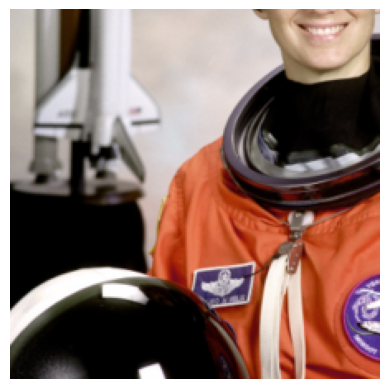

In [60]:
import torch
from torchvision.transforms import v2


transforms = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    v2.RandomResizedCrop(size=(224, 224), antialias=True),# Or Resize(antialias=True)
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Convert NumPy array to torch image
#img_tensor = v2.ToImage()(image)  # converts to torch.Tensor in CHW format
img = transforms(img_tensor)

# Convert back to [0,1] and NumPy for displaying
img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
img = img.clamp(0, 1)  # Clamp to valid range

plt.imshow(img.permute(1, 2, 0).numpy())  # Convert to HWC for display
plt.axis('off')
plt.show()

Tensor image are expected to be of shape (C, H, W), where C is the number of channels, and H and W refer to height and width. Most transforms support batched tensor input. A batch of Tensor images is a tensor of shape (N, C, H, W), where N is a number of images in the batch. The v2 transforms generally accept an arbitrary number of leading dimensions (..., C, H, W) and can handle batched images or batched videos.

Rely on the v2 transforms from torchvision.transforms.v2

Use tensors instead of PIL images

Use torch.uint8 dtype, especially for resizing

Resize with bilinear or bicubic mode

In [ ]:
transforms = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    # ...
    v2.RandomResizedCrop(size=(224, 224), antialias=True),  # Or Resize(antialias=True)
    # ...
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

The above should give you the best performance in a typical training environment that relies on the torch.utils.data.DataLoader.

v2.Resize(size[, interpolation, max_size, ...])    Resize the input to the given size.

v2.ScaleJitter(target_size[, scale_range, ...]) Perform Large Scale Jitter on the input according to "Simple Copy-Paste is a Strong Data Augmentation Method for Instance Segmentation".

v2.RandomShortestSize(min_size[, max_size, ...]) Randomly resize the input.

v2.RandomResize(min_size, max_size[, ...])  Randomly resize the input.

v2.RandomCrop(size[, padding, ...])  Crop the input at a random location.

v2.RandomResizedCrop(size[, scale, ratio, ...]) Crop a random portion of the input and resize it to a given size.

v2.RandomIoUCrop([min_scale, max_scale, ...]) Random IoU crop transformation from "SSD: Single Shot MultiBox Detector".

v2.CenterCrop(size)   Crop the input at the center.

v2.FiveCrop(size) Crop the image or video into four corners and the central crop

v2.TenCrop(size[, vertical_flip]) Crop the image or video into four corners and the central crop plus the flipped version of these (horizontal flipping is used by default).


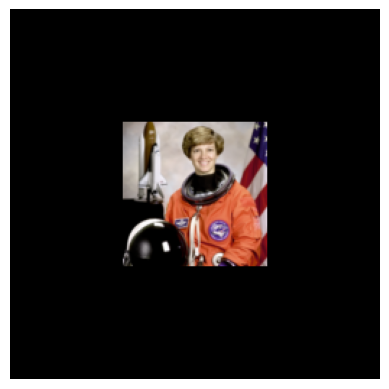

In [ ]:
transforms = v2.Compose([
    v2.Resize(100),
    #v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    v2.CenterCrop(256),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Convert NumPy array to torch image
img_tensor = v2.ToImage()(image)  # converts to torch.Tensor in CHW format
img = transforms(img_tensor)

# Convert back to [0,1] and NumPy for displaying
img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
img = img.clamp(0, 1)  # Clamp to valid range

plt.imshow(img.permute(1, 2, 0).numpy())  # Convert to HWC for display
plt.axis('off')
plt.show()

In [ ]:
#transfrom in batches

In [ ]:
import torch
import torchvision
from torchvision.transforms import v2

# Define the transform pipeline
transforms = v2.Compose([
    v2.ToImage(),  # Ensures input is TensorImage (for v2), replaces ToTensor()
    v2.Resize(256),  # Resize to a size >= crop size
    v2.CenterCrop(224),  # Crop to 224x224 (like ResNet input)
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),  # Converts to float32 and scales to [0,1]
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

# Load CIFAR-10 dataset with the transform
dataset = torchvision.datasets.CIFAR10(root='./Data/Train', download=True, transform=transforms)


ToTensor() or ToImage() converts a PIL image or NumPy array into a PyTorch tensor.

All other v2 transforms like Resize, Crop, Flip, etc., expect tensor input.

So ToTensor() must come before those transforms.

In [ ]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./Data/Train
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 Resize(size=[256], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 CenterCrop(size=(224, 224))
                 RandomHorizontalFlip(p=0.5)
                 ToDtype(scale=True)
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

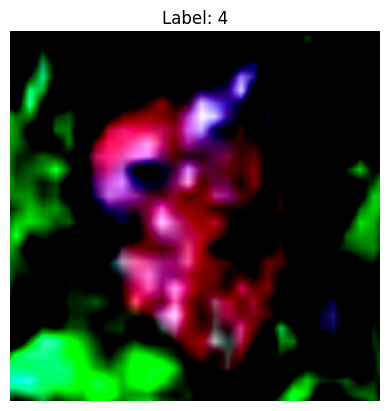

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

# get a batch
image_batch, labels_batch = next(iter(dataloader))

# Show the first image
plt.imshow(image_batch[0].permute(1, 2, 0))  # Convert CHW to HWC
plt.title(f"Label: {labels_batch[0].item()}")
plt.axis("off")
plt.show()

In [ ]:
print(image_batch.shape, labels_batch.shape)

torch.Size([16, 3, 224, 224]) torch.Size([16])


In [ ]:
labels_batch

tensor([4, 7, 9, 1, 2, 7, 9, 7, 2, 0, 8, 9, 6, 3, 6, 3])

each image is associated with a label there are 10 categories of images represented by numeric values  (from 0 to 9)

In [ ]:
img = torchvision.utils.make_grid(image_batch)
img.shape

torch.Size([3, 454, 1810])

we see above the channel (3) is in first dimension

In [ ]:
img = np.transpose(img, (1,2,0))


In [ ]:
img.shape

torch.Size([454, 1810, 3])

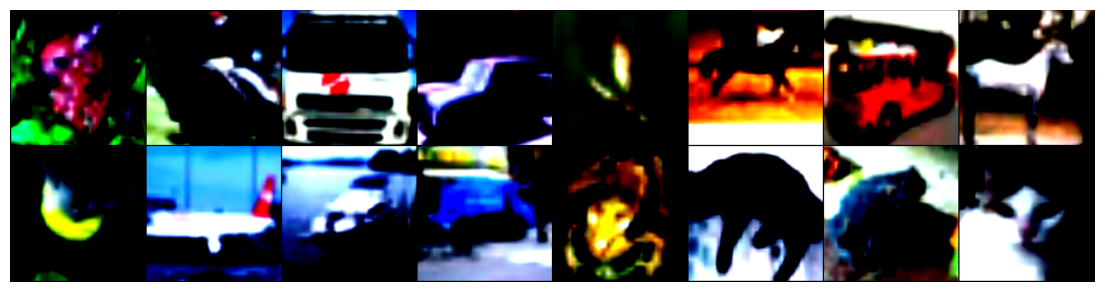

In [ ]:
plt.figure(figsize=(14,10))
plt.imshow(img)
plt.axis('off')
plt.show()

## Normalizing the dataset

In [ ]:
# mean and std for the entire data set
data_mean =[]
data_std = []

for i, data in enumerate(dataloader,0):
    #extract images at index 0
    numpy_image = data[0].numpy()

    # mean and std separatly for every channel
    batch_mean = np.mean(numpy_image, axis =(0, 2, 3))
    batch_std = np.std(numpy_image, axis =(0, 2, 3))

    #apped to the list
    data_mean.append(batch_mean)
    data_std.append(batch_std)

In [ ]:
data_mean =np.array(data_mean)
data_std = np.array(data_std)

data_mean.shape, data_std.shape

((3125, 3), (3125, 3))

In [ ]:
# average of mean and std acros each batch

data_mean = data_mean.mean(axis =0)
data_std  = data_std.mean(axis=0)

print(data_mean)
print(data_std)

In [ ]:
def unnormalize(img_tensor, mean, std):
    """Unnormalize a tensor image using mean and std, returns a numpy image in HWC format."""
    img = img_tensor.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

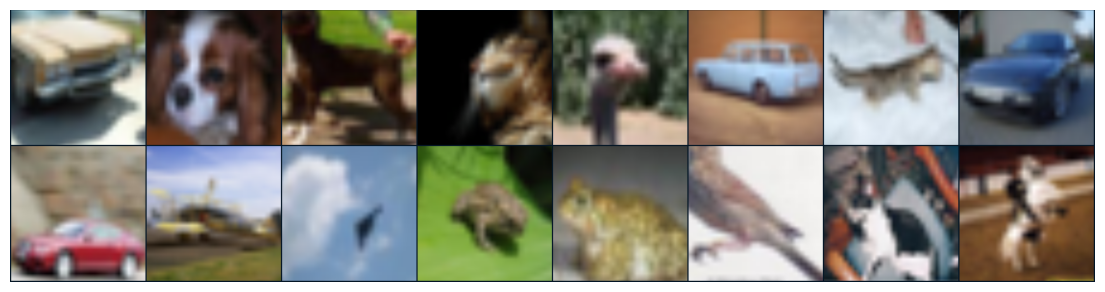

In [ ]:
#applying transforms on the dataset
transform = v2.Compose([
    v2.ToImage(),  # Ensures input is TensorImage (for v2), replaces ToTensor()
    v2.Resize(256),  # Resize to a size >= crop size
    v2.CenterCrop(224),  # Crop to 224x224 (like ResNet input)
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),  # Converts to float32 and scales to [0,1]
    v2.Normalize(data_mean,data_std)
])

# load the CIFAR data again with applying transforms
trainset = torchvision.datasets.CIFAR10(root='./Data/trainset', download = True, transform = transform)

# new data loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 16, shuffle = True, num_workers =2)

#acess one batch of the data
images_batch, labels_batch = next(iter(trainloader))

# Create a grid of images from the batch
img = torchvision.utils.make_grid(images_batch)  # shape: [3, H, W]

# Unnormalize the grid
img = unnormalize(img, data_mean, data_std)       # still [3, H, W]

# Convert to HWC format and NumPy
img = img.permute(1, 2, 0).numpy()                # now [H, W, 3]

# Clip to [0, 1]
img = np.clip(img, 0, 1)

# Show the image grid
plt.figure(figsize=(14, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

Reference : https://docs.pytorch.org/vision/main/transforms.html

Preprocessing using Tensorflow

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

AUTOTUNE = tf.data.AUTOTUNE

# CIFAR-10 normalization stats
data_mean = tf.constant([0.4914, 0.4822, 0.4465])
data_std = tf.constant([0.2023, 0.1994, 0.2010])

# Load CIFAR-10 dataset
(x_train, y_train), _ = tf.keras.datasets.cifar10.load_data()
print("Training data shape:", x_train.shape)

# Convert to tf.data.Dataset
def preprocess_and_augment(image, label):
    image = tf.image.resize(image, [256, 256])
    image = tf.image.random_crop(image, [224, 224, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    image = tf.cast(image, tf.float32) / 255.0
    image = (image - data_mean) / data_std
    return image, label

batch_size = 16

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(preprocess_and_augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(AUTOTUNE)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Training data shape: (50000, 32, 32, 3)


Visualization of One Batch (Unnormalized)

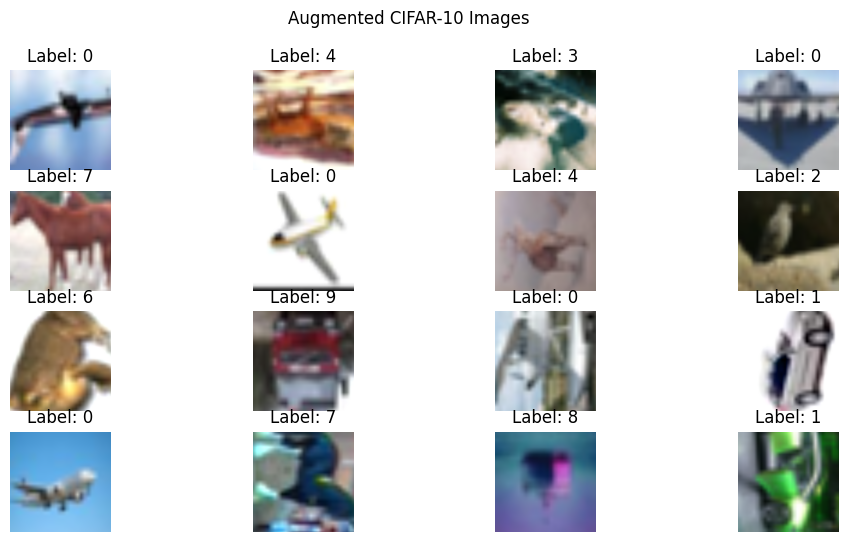

In [ ]:
# Unnormalize function for display
def unnormalize(image_batch):
    return tf.clip_by_value(image_batch * data_std + data_mean, 0, 1)

# Visualize a batch
for images, labels in train_ds.take(1):
    images = unnormalize(images)
    plt.figure(figsize=(12, 6))
    for i in range(min(batch_size, 16)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()[0]}")
        plt.axis('off')
    plt.suptitle("Augmented CIFAR-10 Images")
    plt.show()


Output
Each image is resized, cropped, flipped, color-jittered, and normalized.

Batches are created and prefetching is enabled for performance.

Images are shown unnormalized for correct display.

In [66]:
print("Conclusion")

Conclusion


This Colab contains a comprehensive demonstration of image preprocessing steps using both PyTorch and TensorFlow, along with detailed explanations for each part.

Here's a breakdown of what's included :

Technological Background and Necessity of Preprocessing: The notebook starts with a clear introduction explaining why image preprocessing is essential for deep learning models, covering aspects like standardization of input, normalization, noise reduction, feature enhancement, data augmentation, and computational efficiency.

PyTorch Preprocessing (using torchvision.transforms.v2):

Setup: Imports necessary PyTorch libraries, including torchvision.transforms.v2.

Data Acquisition: Loads a sample image using skimage.data.astronaut() for individual demonstrations.

Deterministic Preprocessing: Defines and explains a v2.Compose pipeline for deterministic steps like v2.ToDtype(torch.uint8, scale=True), v2.Resize, v2.CenterCrop, v2.ToDtype(torch.float32, scale=True), and v2.Normalize. Each transform includes an explanation for its purpose.

Data Augmentation: Demonstrates data augmentation using v2.RandomResizedCrop and v2.RandomHorizontalFlip, along with a note explaining why these random transforms result in different output images every time they are run. The denormalization step for visualization is also explained.

TensorFlow Preprocessing (Individual and Batch Processing):

Data Acquisition: Loads the CIFAR-10 dataset to demonstrate batch processing.

Individual Image Preprocessing (Recap): Briefly recaps converting a PIL image to a TensorFlow tensor, adding a batch dimension, resizing, and normalizing pixel values (to 0-1 and -1 to 1 ranges). It also shows individual data augmentation examples with tf.image functions, again explaining the randomness.

Batch Preprocessing with tf.data.Dataset: This section is well-detailed and crucial:

Why Batch Processing: Explains the importance of batching for computational efficiency, stable gradient estimation, and memory management.

Normalization Statistics: Provides and explains the use of CIFAR-10 specific mean and standard deviation for normalization.

preprocess_and_augment_batch_item function: This function encapsulates a comprehensive set of augmentation steps, including tf.image.resize, tf.image.random_crop, tf.image.random_flip_left_right, tf.image.random_brightness, tf.image.random_contrast, tf.image.random_saturation, and tf.image.rot90. Each step has a comment explaining its purpose.

tf.data.Dataset Pipeline: Demonstrates how to build an efficient data pipeline using:

tf.data.Dataset.from_tensor_slices.

.shuffle(buffer_size=...) with explanation.

.map(..., num_parallel_calls=AUTOTUNE) with explanation.

.batch(batch_size) with explanation.

.prefetch(AUTOTUNE) with explanation.

Visualization: Includes code to visualize an unnormalized batch of augmented CIFAR-10 images to show the effects of batch preprocessing and augmentation.

The notebook is well-structured and provides a thorough explanation of image preprocessing for deep learning using both PyTorch and TensorFlow, making it an excellent resource for students.